# **Business Problem Understanding**

Sebuah perusahaan perhotelan ingin meningkatkan akurasi prediksi terhadap reservasi yang dibatalkan. Pembatalan reservasi memberikan dampak signifikan terhadap pendapatan dan efisiensi hotel karena kamar yang sudah disiapkan tidak terisi dan sumber daya menjadi terbuang.

Melalui data historis terkait pemesanan seperti *country*, *market segment*, *deposit type*, *customer type*, *total of special requests*, dll., perusahaan ingin membangun sistem prediksi yang bisa membantu mengantisipasi pembatalan dan mengambil tindakan yang sesuai.

**Target**

- **0**: Reservasi **tidak dibatalkan**
- **1**: Reservasi **dibatalkan**

**Problem Statement**

Tanpa adanya sistem prediksi, hotel akan kesulitan untuk mempersiapkan diri atas pembatalan yang menyebabkan kerugian baik dari sisi finansial maupun operasional. Proses manajemen reservasi yang tidak efisien bisa berdampak pada pengalaman pelanggan yang buruk dan potensi pendapatan yang hilang.

Perusahaan ingin mengembangkan sistem prediktif yang mampu mengidentifikasi reservasi dengan kemungkinan tinggi untuk dibatalkan sehingga dapat ditindak lebih awal, misalnya dengan menerapkan kebijakan pembayaran di muka atau strategi overbooking yang terukur.

**Goals**

- Memprediksi kemungkinan pembatalan reservasi berdasarkan data historis.

- Mengidentifikasi fitur penting yang mempengaruhi keputusan pembatalan pelanggan.

- Membantu tim manajemen hotel dalam menyusun kebijakan yang lebih proaktif dan efisien.

**Analytic Approach**

Langkah-langkah yang akan dilakukan meliputi:

1. Melakukan eksplorasi dan visualisasi data untuk memahami pola dan distribusi variabel.

2. Membersihkan data dari nilai kosong, outlier, dan melakukan encoding.

3. Membangun model klasifikasi menggunakan algoritma seperti Logistic Regression, Random Forest, XGBoost, dsb.

4. Mengevaluasi performa model berdasarkan metrik yang relevan.

5. Memberikan insight dan rekomendasi berdasarkan hasil analisis.

**Metric Evaluation**

- Type 1 Error (False Positive): Model memprediksi reservasi akan dibatalkan padahal tidak.

Konsekuensi: Hotel mungkin terlalu agresif dalam menerapkan kebijakan seperti overbooking, berpotensi menolak tamu yang sebenarnya akan datang.

- Type 2 Error (False Negative): Model memprediksi reservasi tidak dibatalkan padahal dibatalkan.

Konsekuensi: Hotel menyiapkan kamar untuk tamu yang tidak datang, menyebabkan potensi pendapatan hilang.

Berdasarkan dampak tersebut, model akan difokuskan untuk meminimalkan False Negative, karena kehilangan pendapatan langsung lebih merugikan dibandingkan risiko tindakan preventif yang berlebihan.

Oleh karena itu, metrik utama yang akan digunakan untuk evaluasi model adalah **ROC AUC**, karena metrik ini memperhatikan keseimbangan antara sensitivitas (recall) dan spesifisitas.

# **Attribute Information**

-	**country**: Country of origin.

-	**market_segment**: Market segment designation. 

-	**previous_cancellations**: Number of previous bookings that were cancelled by the customer prior to the current booking.

-	**booking_changes**: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.

-	**deposit_type**: Indication on if the customer made a deposit to guarantee the booking. 

-	**days_in_waiting_list**: Number of days the booking was in the waiting list before it was confirmed to the customer.

-	**customer_type**: Type of booking.

-	**reserved_room_type**: Code of room type reserved. Code is presented instead of designation for anonymity reasons.

-	**required_car_parking_space**: Number of car parking spaces required by the customer.

-	**total_of_special_request**: Number of special requests made by the customer (e.g. twin bed or high floor).

-	**is_canceled:** Value indicating if the booking was canceled (1) or not (0).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
from IPython.display import display

# split
from sklearn.model_selection import train_test_split

# column transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing
# imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer, KNNImputer

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder
from category_encoders.binary import BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# binning
from sklearn.preprocessing import KBinsDiscretizer

# Polynomial
from sklearn.preprocessing import PolynomialFeatures

# Resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

# Cross Validation
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score, cross_validate

# # model Regression
# from sklearn.tree import plot_tree, DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# import statsmodels.api as sm

# model Classification
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


# model ensemble
from sklearn.ensemble import VotingClassifier, StackingClassifier, VotingRegressor, StackingRegressor

# model ensemble similar
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# # scoring regression
# from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# scoring classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, fbeta_score, make_scorer, precision_recall_curve, roc_auc_score

# **Load Dataset**

In [2]:
#Load Dataset
df = pd.read_csv("data_hotel_booking_demand.csv")
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [4]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


# **Data Cleaning**

In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[FRO, LUX]"
1,market_segment,object,0,0.00,8,"[Complementary, Direct]"
2,previous_cancellations,int64,0,0.00,15,"[19, 0]"
3,booking_changes,int64,0,0.00,19,"[12, 10]"
4,deposit_type,object,0,0.00,3,"[No Deposit, Refundable]"
5,days_in_waiting_list,int64,0,0.00,115,"[13, 236]"
6,customer_type,object,0,0.00,4,"[Transient-Party, Contract]"
7,reserved_room_type,object,0,0.00,10,"[E, D]"
8,required_car_parking_spaces,int64,0,0.00,5,"[3, 8]"
9,total_of_special_requests,int64,0,0.00,6,"[4, 2]"


In [6]:
df.duplicated().sum()

73371

Dapat dilihat bahwa data set mempunyai **73371** data duplicate dari **83573** total data yaitu sebesar **87.7%** dari total data. Dikarenakan data duplicate merupakan mayoritas data, maka tidak akan di-drop. Selain dari itu, tidak dapat identifikasi yang unik dari masing-masing customer, jadi juga sangat memungkinkan bila terdapat data yang sama.

In [7]:
df.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

Dikarenakan jumlah NaN sangat kecil dan tidak signifikan, maka akan di-drop

In [8]:
df[df["country"].isna()]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
814,NaN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1166,NaN,Direct,2,0,No Deposit,0,Transient,E,0,3,1
1304,NaN,Direct,0,1,No Deposit,0,Transient,D,0,1,0
1661,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
2182,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
82466,NaN,Offline TA/TO,0,0,No Deposit,0,Transient,A,0,0,0
83084,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
83106,NaN,Direct,0,0,No Deposit,0,Transient,A,0,2,0
83353,NaN,Direct,0,0,No Deposit,0,Transient,A,0,0,0


In [9]:
df.dropna(inplace=True)

In [10]:
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


Pada tahap selanjutnya akan dilihat unique values dari masing-masing column

In [11]:
df["country"].unique()

array(['IRL', 'FRA', 'PRT', 'NLD', 'ESP', 'UMI', 'CN', 'LUX', 'BRA',
       'BEL', 'JPN', 'DEU', 'ITA', 'CHE', 'GBR', 'AGO', 'SRB', 'COL',
       'CHN', 'SWE', 'AUT', 'CIV', 'CZE', 'POL', 'USA', 'SGP', 'RUS',
       'ROU', 'DNK', 'IND', 'MAR', 'PHL', 'ARG', 'ISL', 'ZAF', 'LBN',
       'MOZ', 'TUR', 'BGD', 'MEX', 'CAF', 'NOR', 'FIN', 'UKR', 'EGY',
       'ISR', 'KOR', 'AZE', 'HUN', 'AUS', 'EST', 'CHL', 'SVN', 'PRY',
       'ABW', 'ALB', 'LTU', 'ARE', 'HRV', 'SAU', 'NZL', 'LVA', 'ATA',
       'KAZ', 'DZA', 'TWN', 'CRI', 'BIH', 'BGR', 'IRQ', 'OMN', 'VEN',
       'IDN', 'GEO', 'MLT', 'IRN', 'BLR', 'URY', 'LBY', 'TUN', 'BEN',
       'MYS', 'MWI', 'GRC', 'CYP', 'CPV', 'HKG', 'PRI', 'MKD', 'MUS',
       'IMN', 'PAN', 'NGA', 'GLP', 'KHM', 'PER', 'QAT', 'SEN', 'MAC',
       'SVK', 'BHR', 'ECU', 'SYC', 'BOL', 'TJK', 'LCA', 'MDV', 'SYR',
       'ZMB', 'LIE', 'THA', 'MNE', 'BRB', 'CMR', 'JEY', 'GTM', 'LKA',
       'JOR', 'TZA', 'AND', 'ARM', 'GIB', 'VNM', 'PAK', 'JAM', 'DOM',
       'KWT', 'LAO', 

In [12]:
df["market_segment"].unique()

array(['Offline TA/TO', 'Online TA', 'Direct', 'Groups', 'Corporate',
       'Complementary', 'Aviation', 'Undefined'], dtype=object)

In [13]:
df["market_segment"].value_counts()

market_segment
Online TA        39408
Offline TA/TO    16980
Groups           13718
Direct            8776
Corporate         3668
Complementary      506
Aviation           165
Undefined            1
Name: count, dtype: int64

In [14]:
df = df[df['market_segment'] != 'Undefined']

Dalam column 'market_segment' terdapat satu Undefined, maka akan dikeluarkan

In [15]:
df["deposit_type"].unique()

array(['No Deposit', 'Non Refund', 'Refundable'], dtype=object)

In [16]:
df["deposit_type"].value_counts()

deposit_type
No Deposit    73011
Non Refund    10100
Refundable      110
Name: count, dtype: int64

In [17]:
df["customer_type"].unique()

array(['Transient-Party', 'Transient', 'Contract', 'Group'], dtype=object)

In [18]:
df["customer_type"].value_counts()

customer_type
Transient          62414
Transient-Party    17506
Contract            2882
Group                419
Name: count, dtype: int64

In [19]:
df["reserved_room_type"].value_counts()

reserved_room_type
A    59761
D    13505
E     4621
F     2032
G     1438
B      786
C      672
H      401
L        3
P        2
Name: count, dtype: int64

# **EDA**

In [20]:
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


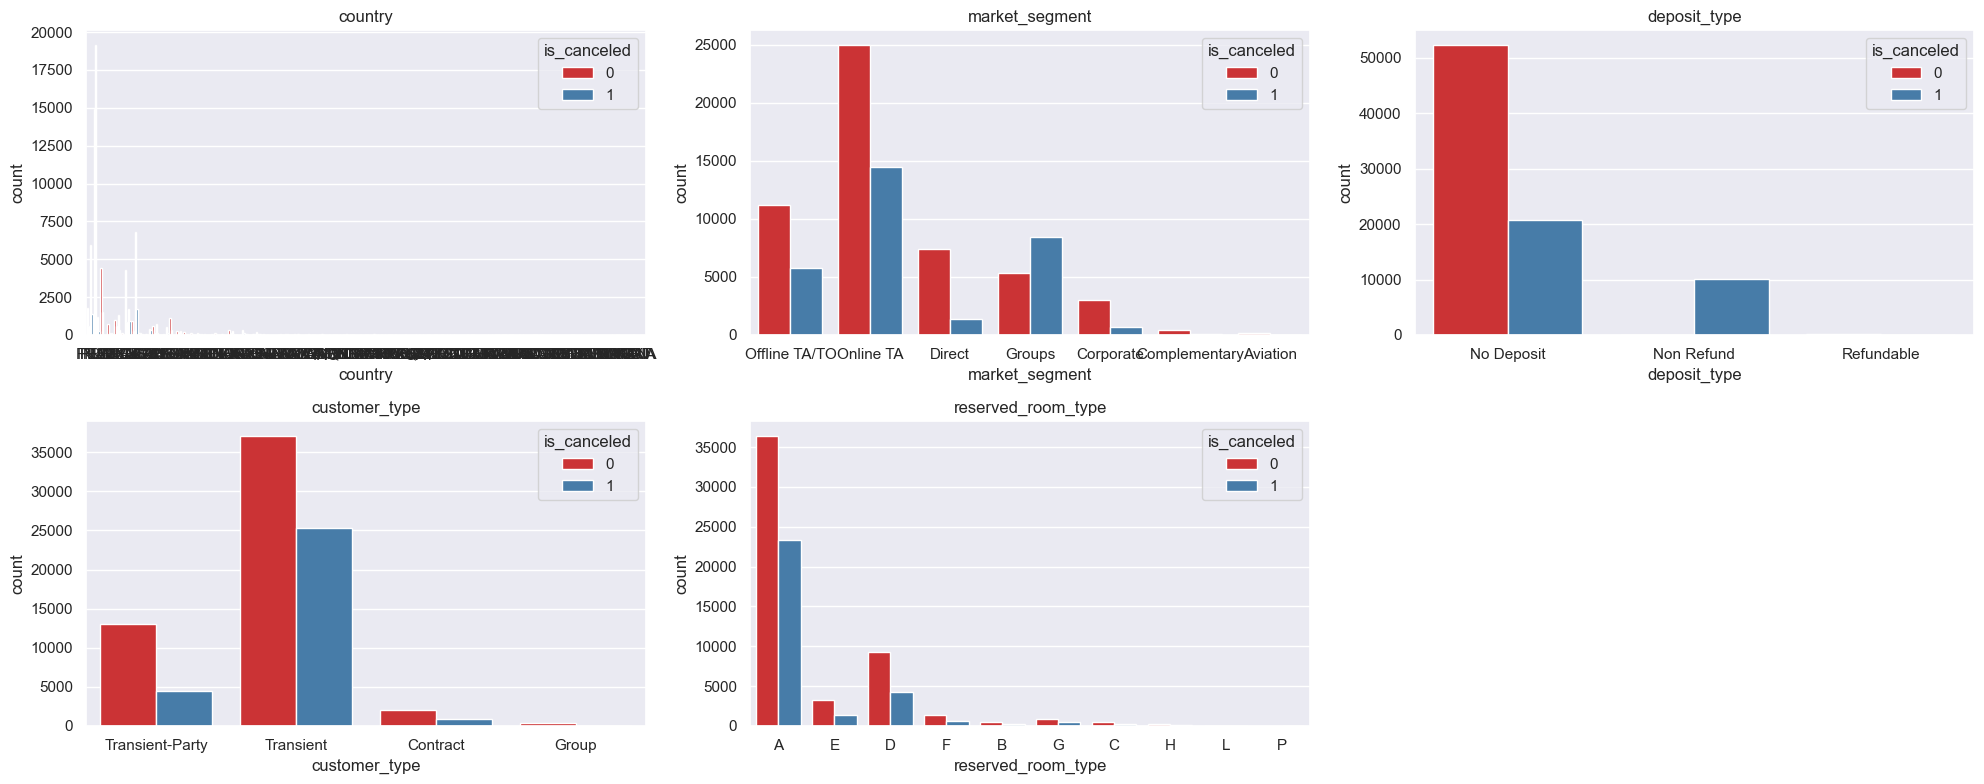

In [21]:
features = ['country', 'market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']
plt.figure(figsize=(20, 8))
sns.set(palette='Set1')
plotnumber = 1

for feature in features:
    ax = plt.subplot(2, 3, plotnumber)
    sns.countplot(x=feature, hue='is_canceled', data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

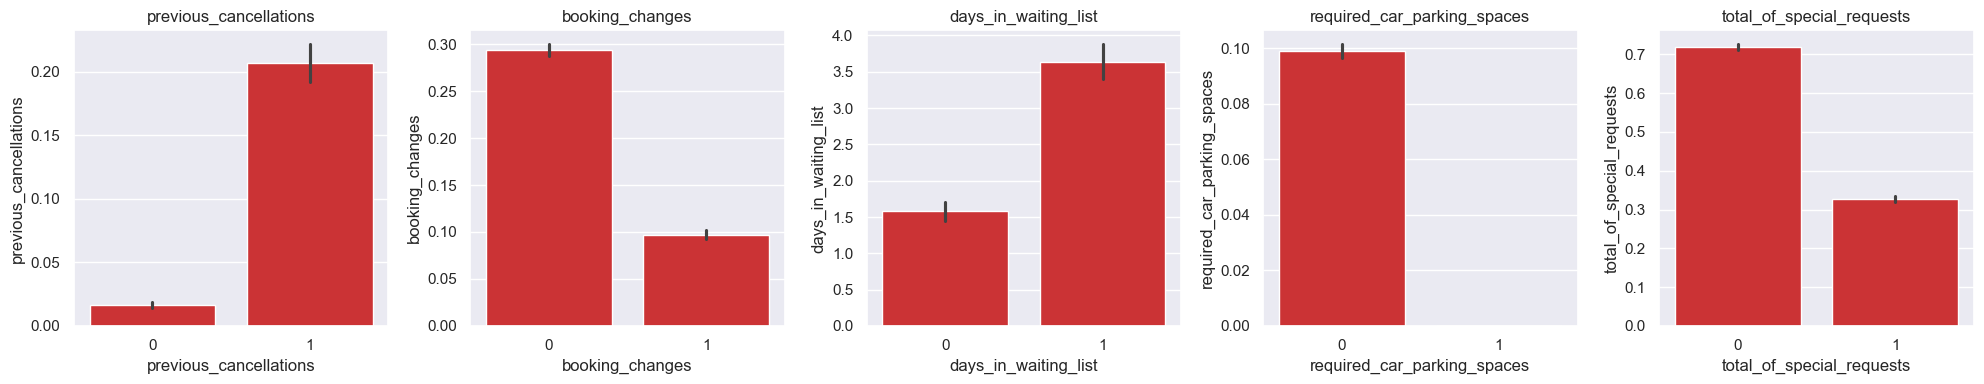

In [22]:
num_features = ['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']
plt.figure(figsize=(20, 4))
plotnumber = 1

for feat in num_features:
    ax = plt.subplot(1, len(num_features), plotnumber)
    sns.barplot(x='is_canceled', y=feat, data=df)
    plt.xlabel(feat)
    plt.title(feat)
    plotnumber += 1
    plt.tight_layout();

In [23]:
from scipy.stats import mannwhitneyu

In [24]:
for feat in num_features:

    stat, pvalue = mannwhitneyu(
        df[df['is_canceled']==0][feat],
        df[df['is_canceled']==1][feat],    
    )

    if pvalue < 0.05:
        hasil = 'terkait'
    else:
        hasil = 'TIDAK terkait'

    print(pvalue.round(4), f'\t is_canceled vs {feat} --> {hasil}')

0.0 	 is_canceled vs previous_cancellations --> terkait
0.0 	 is_canceled vs booking_changes --> terkait
0.0 	 is_canceled vs days_in_waiting_list --> terkait
0.0 	 is_canceled vs required_car_parking_spaces --> terkait
0.0 	 is_canceled vs total_of_special_requests --> terkait


Selanjutnya kita lihat keterkaitan antara feature numerik dengan is_canceled, dan dapat dilihat bahwa semuanya terkait.

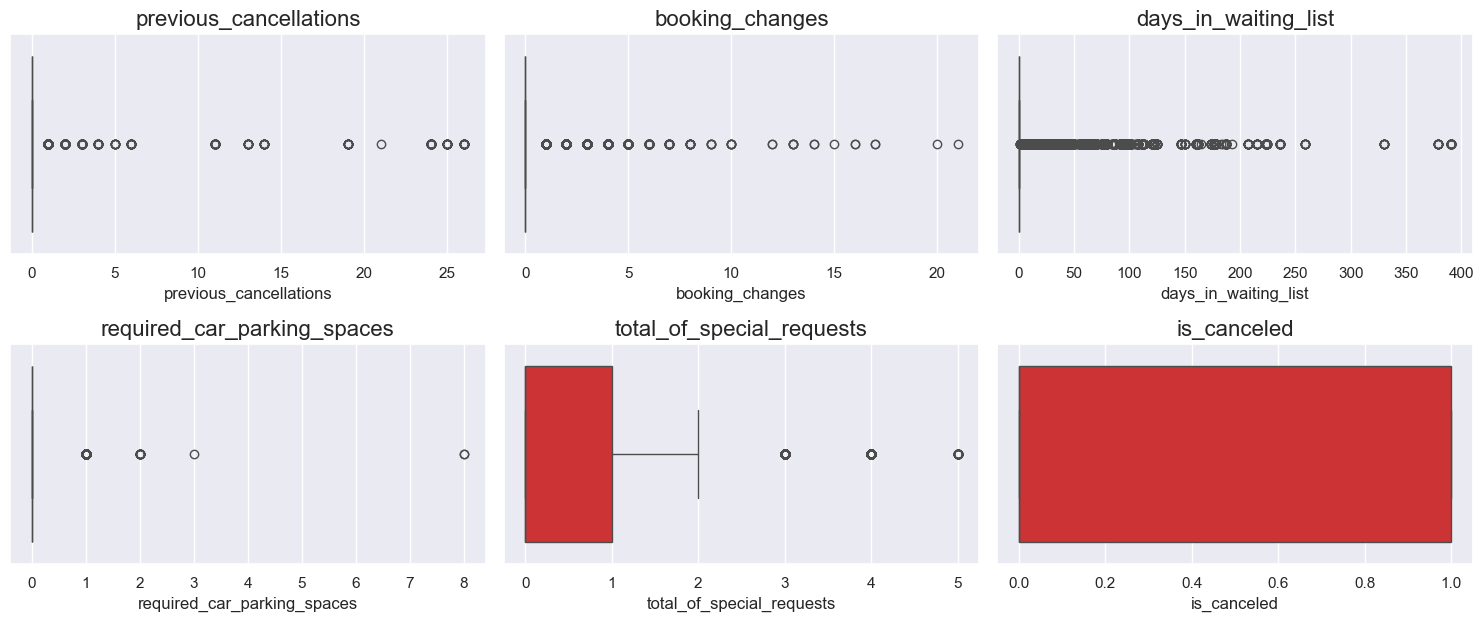

In [25]:
num_feature = df.describe().columns
plt.figure(figsize=(15, 9), facecolor='white')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(3,3, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber = plotnumber + 1

Pada tahap selanjutnya akan menganalisa outliers yang dapat mendistorsi hasil machine learning dan akan drop sebagian dari ouliers tersebut

In [26]:
df = df[df["previous_cancellations"] <10]

In [27]:
df = df[df["booking_changes"] <= 10]

In [28]:
df = df[df["days_in_waiting_list"] <= 250]

In [29]:
df = df[df["required_car_parking_spaces"] <= 4]

In [30]:
df = df[df["total_of_special_requests"] <= 4]

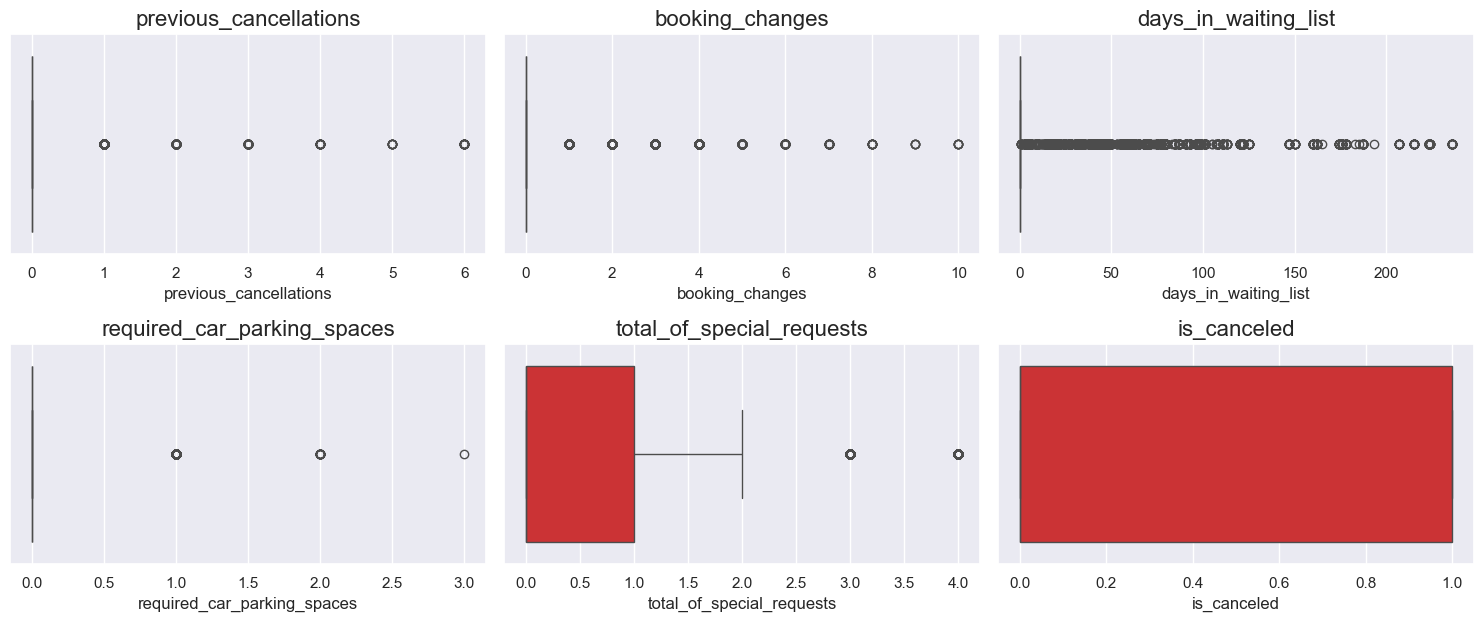

In [31]:
num_feature = df.describe().columns
plt.figure(figsize=(15, 9), facecolor='white')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(3,3, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber = plotnumber + 1

Boxplot di atas merupakan hasil akhir setelah penghapusan sebagian dari outliers

In [32]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,82986.000000,82986.000000,82986.000000,82986.000000,82986.000000,82986.000000
mean,0.056793,0.218386,2.082038,0.062276,0.572916,0.368556
std,0.264721,0.616646,14.841116,0.242900,0.791192,0.482416
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6.000000,10.000000,236.000000,3.000000,4.000000,1.000000


# **Define X and y**

Pada tahap ini akan didefinisikan X dan y dari dataset

X : features/independent variable

y : target/dependent variable

In [33]:
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [34]:
X = df.drop(columns="is_canceled")
X.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2


In [35]:
y = df["is_canceled"]
y.head()

0    0
1    0
2    0
3    1
4    0
Name: is_canceled, dtype: int64

# **Data Splitting**

Setelah mendapatkan X dan y, maka akan displit menjadi train set dan test set.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

# **Data Preprocessing**

Sebelum membangun model machine learning, kita perlu melakukan preprocessing agar data dalam format yang sesuai dan optimal untuk algoritma klasifikasi. Tidak semua fitur bisa langsung digunakan oleh model karena:

- Model tidak dapat memahami data kategorikal secara langsung.

- Beberapa fitur numerik memiliki distribusi yang sangat miring dan perlu diskalakan.

- Fitur berbeda memerlukan metode transformasi yang berbeda.

Untuk itu, digunakan pendekatan preprocessing sebagai berikut:

1. One-Hot Encoding
Digunakan untuk fitur kategorikal non-ordinal (tidak memiliki urutan alami), seperti:

**reserved_room_type, customer_type, deposit_type, market_segment**

Tujuan: Mengubah kategori menjadi representasi biner (0 dan 1) agar bisa digunakan oleh model tanpa mengasumsikan hubungan urutan antar kategori.

2. Binary Encoding
Digunakan untuk fitur kategorikal dengan dua kemungkinan nilai unik seperti:

**country** (jika telah disederhanakan atau dibagi menjadi dua kelas seperti "Portugal" vs "others", misalnya)

Tujuan: Menyederhanakan representasi fitur menjadi 0/1 tanpa membuat banyak kolom seperti pada one-hot encoding.

3. Robust Scaling
Digunakan untuk fitur numerik yang rawan outlier, seperti:

**previous_cancellations, booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_requests**

Tujuan: Mengurangi pengaruh outlier dengan cara menskalakan data berdasarkan interquartile range (IQR). Lebih stabil dibandingkan StandardScaler atau MinMaxScaler jika data memiliki nilai ekstrim.

****Manfaat dari Proses Ini****

Menyediakan representasi fitur yang sesuai dengan kebutuhan algoritma klasifikasi.

Menjaga skala fitur numerik agar tidak mendominasi perhitungan model.

Menangani outlier dan kategori dengan cara yang tepat.


In [37]:
# define transformer
transformer = ColumnTransformer([
    ("onehot", OneHotEncoder(), ["reserved_room_type", "customer_type", "deposit_type","market_segment"]),
    ("binary", BinaryEncoder(),["country"]),
    ("robust", RobustScaler(), ["previous_cancellations", "booking_changes", "days_in_waiting_list", "required_car_parking_spaces", "total_of_special_requests"])
])

# fit
transformer.fit(X_train)

# transform
X_train_prep = transformer.transform(X_train)
X_test_prep = transformer.transform(X_test)

In [38]:
transformer

ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                 ['reserved_room_type', 'customer_type',
                                  'deposit_type', 'market_segment']),
                                ('binary', BinaryEncoder(), ['country']),
                                ('robust', RobustScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests'])])

In [39]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

# **Model Benchmarking**

In [40]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'std':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

[LightGBM] [Info] Number of positive: 19574, number of negative: 33536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 53110, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368556 -> initscore=-0.538417
[LightGBM] [Info] Start training from score -0.538417


c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19574, number of negative: 33536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 53110, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368556 -> initscore=-0.538417
[LightGBM] [Info] Start training from score -0.538417


c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19574, number of negative: 33536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 53110, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368556 -> initscore=-0.538417
[LightGBM] [Info] Start training from score -0.538417


c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19575, number of negative: 33536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 53111, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368568 -> initscore=-0.538366
[LightGBM] [Info] Start training from score -0.538366


c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19575, number of negative: 33536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 53111, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368568 -> initscore=-0.538366
[LightGBM] [Info] Start training from score -0.538366


c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,mean roc_auc,std
model,,
XGBoost,0.893379,0.003326
LightGBM,0.893344,0.003654
Random Forest,0.887232,0.003093
Decision Tree,0.875620,0.002231
Logistic Regression,0.849679,0.005611
KNN,0.843250,0.011063


XGBoost dan LightGBM mengungguli model lain, dengan skor ROC AUC rata-rata tertinggi dan varians yang relatif rendah.

Berdasarkan hasil ini, XGBoost atau LightGBM adalah kandidat kuat untuk tuning lebih lanjut.

# **Model Benchmarking (Test Data)**

In [41]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 
               precision    recall  f1-score   support

           0       0.78      0.91      0.84     10481
           1       0.78      0.55      0.65      6117

    accuracy                           0.78     16598
   macro avg       0.78      0.73      0.74     16598
weighted avg       0.78      0.78      0.77     16598

KNN 
               precision    recall  f1-score   support

           0       0.80      0.87      0.83     10481
           1       0.73      0.63      0.68      6117

    accuracy                           0.78     16598
   macro avg       0.77      0.75      0.76     16598
weighted avg       0.78      0.78      0.78     16598

Decision Tree 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85     10481
           1       0.76      0.69      0.72      6117

    accuracy                           0.80     16598
   macro avg       0.79      0.78      0.78     16598
weighted avg       0.80      0

c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,roc_auc score
model,
XGBoost,0.893066
LightGBM,0.892276
Random Forest,0.887129
Decision Tree,0.876545
Logistic Regression,0.847798
KNN,0.843158


Setelah dilakukan evaluasi terhadap berbagai model klasifikasi menggunakan metrik ROC AUC dan classification report, diperoleh bahwa model XGBoost menunjukkan performa terbaik dengan ROC AUC score sebesar 0.893066 pada data test set.

# **Hyperparameter Tuning**

In [50]:
xgb = XGBClassifier()
ros = RandomOverSampler(random_state=42)

estimator = Pipeline([
    ('oversampling', ros),
    ('preprocess', transformer),  # Make sure transformer is defined
    ('model', xgb)
])

In [51]:
hyperparam_space = {
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.7, 0.8, 1],
    'model__colsample_bytree': [0.7, 0.8, 1],
    'model__random_state': [42]
}

In [52]:
grid = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    scoring='roc_auc',  # good for classification especially with imbalance
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1
)

In [53]:
grid.fit(X_train,y_train)
print("best score:", grid.best_score_)
print("best params:",grid.best_params_)

c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


best score: 0.8942799689833659
best params: {'model__colsample_bytree': 1, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__random_state': 42, 'model__subsample': 0.7}


n_estimators = 200: Model terbaik memerlukan jumlah pohon yang besar untuk menangkap pola dengan baik.

max_depth = 7: Pohon dengan kedalaman sedang mampu menangkap kompleksitas tanpa overfitting.

learning_rate = 0.1: Laju pembelajaran yang relatif tinggi mempercepat konvergensi model.

subsample = 0.7: Menggunakan 70% data untuk tiap pohon membuat model lebih robust dan tidak mudah overfit.

colsample_bytree = 1: Menggunakan semua fitur untuk tiap pohon (tidak ada pengurangan fitur).

random_state = 42: Dipilih untuk konsistensi dan replikasi hasil eksperimen.

Dengan kombinasi hyperparameter di atas, model berhasil mencapai cross-validation score tertinggi sebesar **0.8943**

In [54]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['reserved_room_type',
                                                   'customer_type',
                                                   'deposit_type',
                                                   'market_segment']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country']),
                                                 ('robust', RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'requir...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [55]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',xgb)
])
estimator.fit(X_train, y_train)

c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['reserved_room_type',
                                                   'customer_type',
                                                   'deposit_type',
                                                   'market_segment']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country']),
                                                 ('robust', RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'requir...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [56]:
y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default XGB : ', roc_auc_default)
print('ROC AUC Score Tuned XGB : ', roc_auc_tuned)

ROC AUC Score Default XGB :  0.8925152744146023
ROC AUC Score Tuned XGB :  0.8926490475451372


Setelah dilakukan proses tuning dengan menggunakan hyperparameter yang terbaik, maka didapatkan score lebih baik yaitu 0.892649

In [57]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default XGB : \n', report_default)
print('Classification Report Tuned XGB : \n', report_tuned)

Classification Report Default XGB : 
               precision    recall  f1-score   support

           0       0.87      0.80      0.83     10481
           1       0.70      0.79      0.74      6117

    accuracy                           0.80     16598
   macro avg       0.78      0.80      0.79     16598
weighted avg       0.80      0.80      0.80     16598

Classification Report Tuned XGB : 
               precision    recall  f1-score   support

           0       0.87      0.80      0.83     10481
           1       0.70      0.79      0.74      6117

    accuracy                           0.80     16598
   macro avg       0.78      0.79      0.79     16598
weighted avg       0.80      0.80      0.80     16598



# **Confusion Matrix**

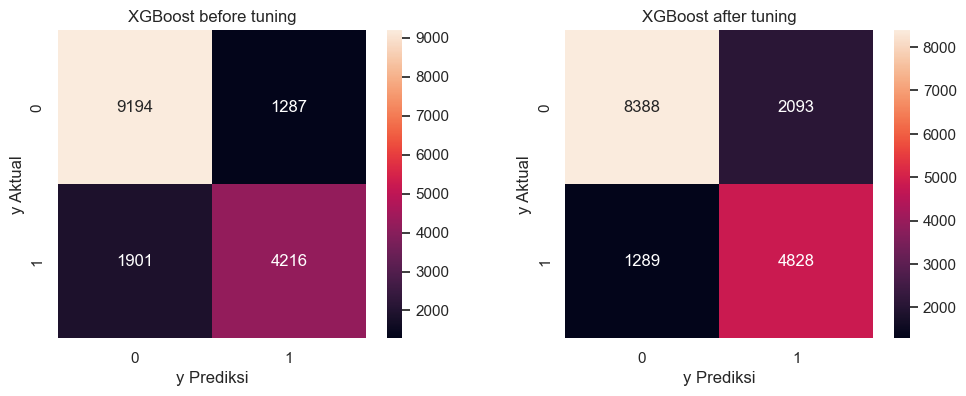

In [58]:
plt.figure(figsize=(12,4))

# Model XGBoost before tuning
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('XGBoost before tuning')

# Model XGBoost after tuning
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('XGBoost after tuning');

Model yang Tuned lebih sesuai dengan tujuan untuk memaksimalkan ROC AUC dan meminimalkan False Negative. Model ini berhasil mengidentifikasi lebih banyak hasil positif aktual, sehingga mengurangi risiko terlewatnya kasus positif penting.

Peningkatan false positive merupakan sebuah kompensasi, tetapi dalam banyak operasi hotel, lebih baik mempersiapkan pembatalan yang tidak terjadi daripada terkejut karenanya.

In [73]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Get the best model
best_xgb = grid.best_estimator_

# 2. Predict on the test set
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# 3. Evaluate performance
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83     10481
           1       0.70      0.79      0.74      6117

    accuracy                           0.80     16598
   macro avg       0.78      0.79      0.79     16598
weighted avg       0.80      0.80      0.80     16598


ROC AUC Score: 0.8926490475451372


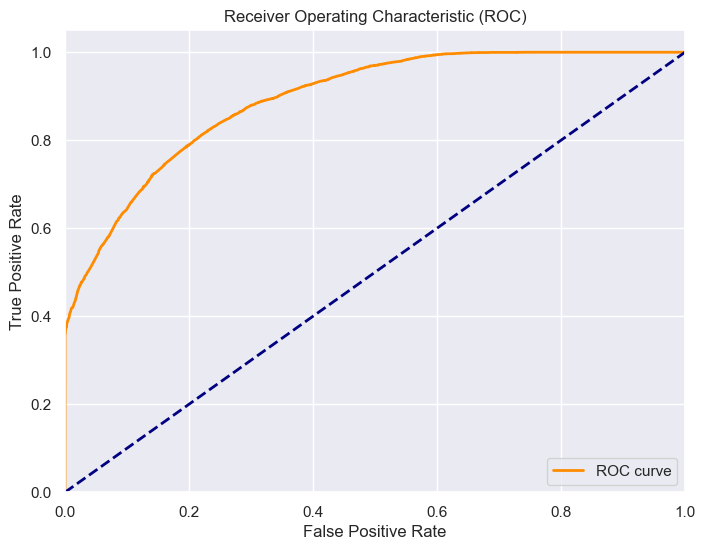

In [74]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Feature Importance**

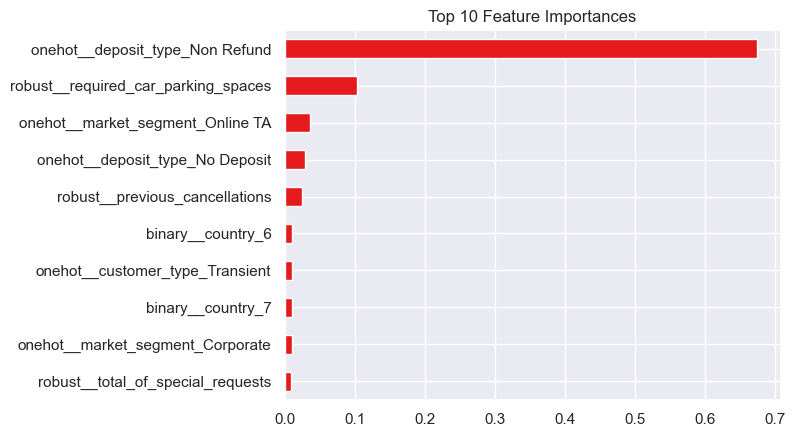

In [75]:
importances = best_xgb.named_steps['model'].feature_importances_
feature_names = transformer.get_feature_names_out()
feat_imp_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 10
feat_imp_df.head(10).plot(kind='barh', title='Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Dapat dilihat bahwa feature yang paling berpengaruh merupakan **deposit_type_Non_Refund**, dan diikuti oleh **required_car_parking_spaces**, dan **market_segment_Online_TA**

# **Conclusion**

Berdasarkan hasil classification report dan skor ROC AUC, kita dapat menyimpulkan bahwa model XGBoost (baik default maupun setelah tuning) memiliki performa yang stabil dan andal untuk memprediksi hotel resevation cancellation.

- ROC AUC Score Tuned XGBoost: 0.8926

    - Menunjukkan bahwa model memiliki kemampuan 89.26% dalam membedakan antara reservasi yang dibatalkan dan yang tidak.
    - Model ini dapat dipercaya untuk mengurutkan risiko pembatalan, yang penting untuk pengambilan keputusan bisnis preventif.

- Recall Class 1 (Dibatalkan): 79%

    - Model berhasil mendeteksi sebagian besar pembatalan aktual, sehingga hotel dapat melakukan intervensi lebih awal.

- Precision Class 1: 70%

    - Dari seluruh prediksi pembatalan, 70% di antaranya benar-benar dibatalkan, yang menunjukkan tingkat keakuratan intervensi yang baik.

**Estimasi Dampak Bisnis**

Asumsi:
- Kerugian 1 pembatalan tak terdeteksi (FN): $100
- Biaya preventif untuk 1 FP: $20

Tanpa Model:
- 3700 pembatalan x $100 = $370,000 kerugian

Dengan Model:
- FN (1284 x $100) = $128,400
- FP (2096 x $20) = $41,920

Total biaya: $170,320

Penghematan per bulan: $199,680

# **Recommendation**

1. Gunakan model Tuned XGBoost sebagai sistem prediksi utama karena memiliki ROC AUC tinggi dan stabilitas performa.

2. Integrasikan skor probabilitas ke dalam sistem reservasi untuk:
    - Menentukan risiko pembatalan setiap reservasi
    - Memberikan penawaran khusus kepada pelanggan berisiko tinggi

3. Terapkan threshold adaptif tergantung musim, hari libur, atau okupansi.

4. Fokuskan strategi pada pengurangan False Negative, karena dampaknya paling besar terhadap pendapatan.

5. Lakukan monitoring performa model (ROC AUC & confusion matrix) secara berkala dan retraining model secara periodik.

**Saving**

In [76]:
import pickle

In [77]:
# define
best_xgb = grid.best_estimator_

# fitting
best_xgb.fit(X, y)

# saving
pickle.dump(best_xgb, open("Hotel_booking_model.sav", "wb"))

c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Gerald\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [78]:
model = pickle.load(open("Hotel_booking_model.sav", "rb"))
model

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['reserved_room_type',
                                                   'customer_type',
                                                   'deposit_type',
                                                   'market_segment']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country']),
                                                 ('robust', RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'requir...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])